In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import pickle

In [47]:
# 1. Load dataset
df = pd.read_csv("../data/ais_cleaned.csv")

In [48]:
features = ['Latitude', 'Longitude', 'SOG', 'COG', 'Heading', 'VesselType', 'Length', 'Width', 'Status']
targets = ['Latitude_next', 'Longitude_next']

In [49]:
df.dropna(subset=features + targets, inplace=True)

In [50]:
X = df[features]
y = df[targets]

In [51]:
X = pd.get_dummies(X, columns=['VesselType', 'Status'], drop_first=True)

In [52]:
# 6. Standardize numerical columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
with open("../models/scaler_features.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [54]:
# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [78]:
y_train,y_test

(     Latitude_next  Longitude_next
 145      48.517059     -122.585632
 9        46.202264     -123.817848
 374      34.138485     -119.364792
 521      30.169694      -93.359860
 188      35.606560      -76.000069
 ..             ...             ...
 71       26.060340      -80.131120
 106      47.339287     -122.584050
 270      38.818740      -82.104910
 435      34.748820      -92.242010
 102      32.724010     -117.223550
 
 [478 rows x 2 columns],
      Latitude_next  Longitude_next
 110      49.181088     -123.589511
 287      45.606716     -122.686081
 563      36.588819     -125.829507
 77       36.589305      -75.986044
 181      40.699461      -91.119535
 ..             ...             ...
 398      46.500160      -84.338100
 433      32.129540      -92.088170
 148      37.078462      -89.202206
 493      33.747730     -118.198790
 438      40.033590      -73.998042
 
 [120 rows x 2 columns])

In [55]:
# 8. Define models
base_models = {
    'LinearRegression': LinearRegression(),
    'RidgeRegression': Ridge(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
}

In [56]:
models = {name: MultiOutputRegressor(model) for name, model in base_models.items()}

In [67]:
# 9. Train and evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_test, y_pred)
    print(f"{name} - Train R2: {r2_train}, Test R2: {r2_test}")

    mse_lat = mean_squared_error(y_test['Latitude_next'], y_pred[:, 0])
    mse_lon = mean_squared_error(y_test['Longitude_next'], y_pred[:, 1])
    rmse_lat = np.sqrt(mse_lat)
    rmse_lon = np.sqrt(mse_lon)
    mae_lat = mean_absolute_error(y_test['Latitude_next'], y_pred[:, 0])
    mae_lon = mean_absolute_error(y_test['Longitude_next'], y_pred[:, 1])
    r2 = r2_score(y_test, y_pred)
    
    with open(f"../models/model_{name.lower()}.pkl", "wb") as f:
        pickle.dump(model, f)


    results.append({
        'Model': name,
        'R2_Score': r2,
        'RMSE_Latitude':rmse_lat,
        'RMSE_Longitude':rmse_lon,
        'MAE_Latitude':mae_lat,
        'MAE_Longitude':mae_lon
    })

LinearRegression - Train R2: 0.9999578214402505, Test R2: 0.9999230958760177
RidgeRegression - Train R2: 0.9999525802188634, Test R2: 0.9999204567819704
RandomForest - Train R2: 0.9999136171043059, Test R2: 0.9998187116419086
GradientBoosting - Train R2: 0.9999834383636224, Test R2: 0.999865305163528


In [68]:
results_df = pd.DataFrame(results)
print("\n=== Model Evaluation Results ===")
print(results_df)


=== Model Evaluation Results ===
              Model  R2_Score  RMSE_Latitude  RMSE_Longitude  MAE_Latitude  \
0  LinearRegression  0.999923       0.074742        0.093821      0.041692   
1   RidgeRegression  0.999920       0.074392        0.108835      0.043965   
2      RandomForest  0.999819       0.105253        0.210334      0.066152   
3  GradientBoosting  0.999865       0.094959        0.155036      0.059049   

   MAE_Longitude  
0       0.060668  
1       0.078727  
2       0.107076  
3       0.096341  


In [69]:
results_df.to_csv("../results/regression_results.csv", index=False)


In [65]:
import pandas as pd

# Combine actual and predicted into a DataFrame
comparison_df = pd.DataFrame({
    'Latitude_actual': y_test['Latitude_next'].values,
    'Longitude_actual': y_test['Longitude_next'].values,
    'Latitude_predicted': y_pred[:, 0],
    'Longitude_predicted': y_pred[:, 1]
})

# Optionally, reset index for clarity
comparison_df.reset_index(drop=True, inplace=True)

# Save to CSV
comparison_df.to_csv("../results/predicted_vs_actual_coordinates.csv", index=False)

print("Saved to ../results/predicted_vs_actual_coordinates.csv")


Saved to ../results/predicted_vs_actual_coordinates.csv


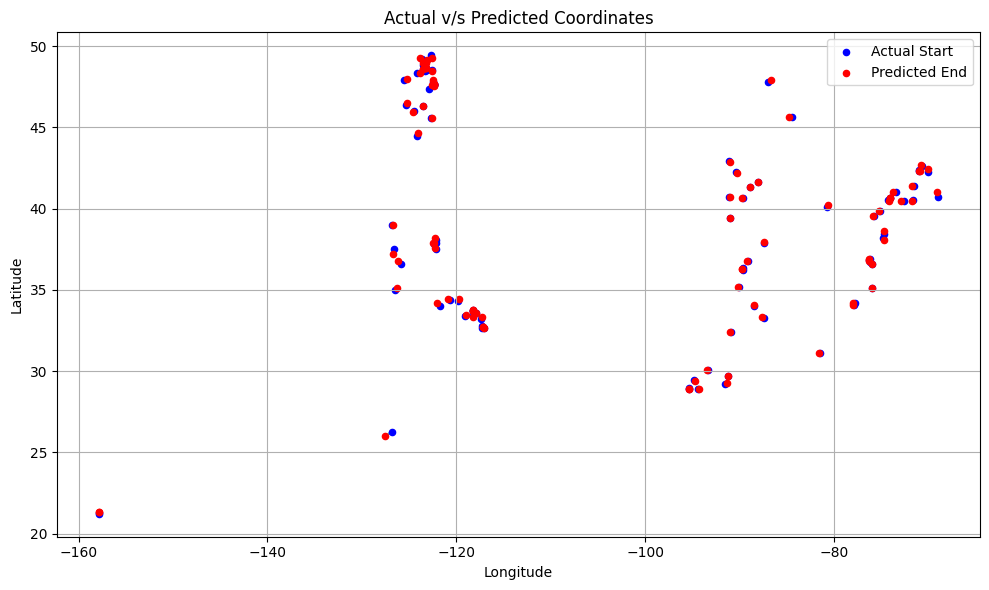

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Sample size to keep plot readable
sample_n = 100

# Actual start points (x, y)
x = y_test['Longitude_next'].values[:sample_n]
y = y_test['Latitude_next'].values[:sample_n]

# Predicted points (a, b)
a = y_pred[:sample_n, 1]
b = y_pred[:sample_n, 0]

# Vector differences
u = a - x
v = b - y

plt.figure(figsize=(10, 6))
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='teal', alpha=0.7)
plt.scatter(x, y, color='blue', label='Actual Start', s=20)
plt.scatter(a, b, color='red', label='Predicted End', s=20)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Actual v/s Predicted Coordinates")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("../results/actual_to_predicted.png")
plt.show()


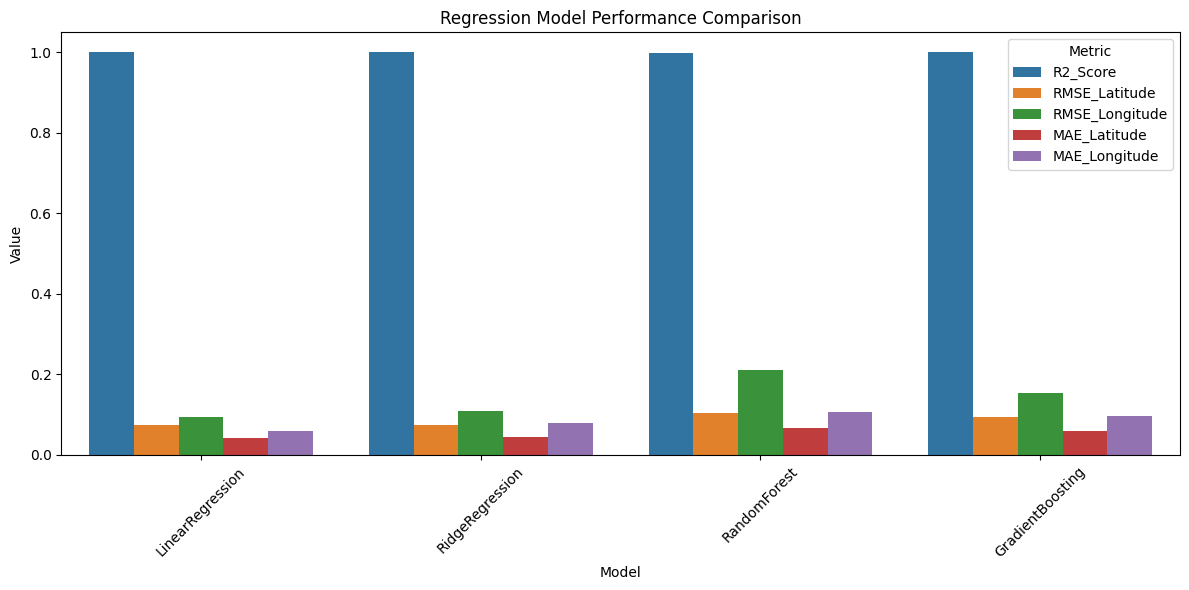

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
results_df = pd.read_csv("../results/regression_results.csv")

# Convert to long format
results_melted = results_df.melt(id_vars='Model', 
                                 value_vars=['R2_Score', 'RMSE_Latitude', 'RMSE_Longitude', 
                                             'MAE_Latitude', 'MAE_Longitude'],
                                 var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Value', hue='Metric', data=results_melted)
plt.title("Regression Model Performance Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../results/performance_comparison.png")
plt.show()
